**Load Hyperspectral Data and Ground Truth & Check their shapes**

we import required libraries, load the`.npy` data files, and print their shapes to confirm spatial and spectral dimensions.

In [18]:
import numpy as np
import matplotlib.pyplot as plt

gt = np.load('/content/IPgt.npy')
data = np.load('/content/indianpinearray.npy')

print("Data shape: ",data.shape)
print("Ground Truth shape:",gt.shape)


Data shape:  (145, 145, 200)
Ground Truth shape: (145, 145)


**Finding All Unique Class Labels Present in the Ground Truth**

We extract unique integer values from the GT mask to know how many classes are available and which labels exist in this dataset version.


In [19]:
classes = np.unique(gt)
print("Unique class labels:",classes)
print("Number of unique classes:",len(classes))

Unique class labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
Number of unique classes: 17


**Define Class Label → Class Name Mapping from Official Documentation**

We create a Python dictionary that maps each integer class label in the ground truth to its corresponding crop/land-cover name.


In [20]:
# Mapping from class ID to class name based on official Indian Pines documentation
class_names = {
    0: "Background / Unknown",
    1: "Alfalfa",
    2: "Corn-notill",
    3: "Corn-mintill",
    4: "Corn",
    5: "Grass-pasture",
    6: "Grass-trees",
    7: "Grass-pasture-mowed",
    8: "Hay-windrowed",
    9: "Oats",
    10: "Soybean-notill",
    11: "Soybean-mintill",
    12: "Soybean-clean",
    13: "Wheat",
    14: "Woods",
    15: "Buildings-Grass-Trees-Drives",
    16: "Stone-Steel-Towers"
}

# Just to verify:
for c in np.unique(gt):
    print(c, "→", class_names.get(c, "Unknown"))

0 → Background / Unknown
1 → Alfalfa
2 → Corn-notill
3 → Corn-mintill
4 → Corn
5 → Grass-pasture
6 → Grass-trees
7 → Grass-pasture-mowed
8 → Hay-windrowed
9 → Oats
10 → Soybean-notill
11 → Soybean-mintill
12 → Soybean-clean
13 → Wheat
14 → Woods
15 → Buildings-Grass-Trees-Drives
16 → Stone-Steel-Towers


**Count Number of Pixels in Each Class**

We calculate how many pixels belong to each class label in the GT map.  
This reveals class imbalance and helps us understand dataset difficulty.


In [21]:
unique_classes = np.unique(gt)

class_pixel_counts = {}

for c in unique_classes:
    count = np.sum(gt == c)
    class_pixel_counts[c] = count

# Print neatly
for c in unique_classes:
    print(f"Class {c:2d} ({class_names.get(c, 'Unknown'):>30}): {class_pixel_counts[c]}")


Class  0 (          Background / Unknown): 10776
Class  1 (                       Alfalfa): 46
Class  2 (                   Corn-notill): 1428
Class  3 (                  Corn-mintill): 830
Class  4 (                          Corn): 237
Class  5 (                 Grass-pasture): 483
Class  6 (                   Grass-trees): 730
Class  7 (           Grass-pasture-mowed): 28
Class  8 (                 Hay-windrowed): 478
Class  9 (                          Oats): 20
Class 10 (                Soybean-notill): 972
Class 11 (               Soybean-mintill): 2455
Class 12 (                 Soybean-clean): 593
Class 13 (                         Wheat): 205
Class 14 (                         Woods): 1265
Class 15 (  Buildings-Grass-Trees-Drives): 386
Class 16 (            Stone-Steel-Towers): 93


 **Visualize Ground Truth Class Map (colored) and legend**

This cell plots the ground-truth label matrix as a colored image and shows a legend mapping class IDs → class names. Run this in Colab after you have `gt` and `class_names` loaded.


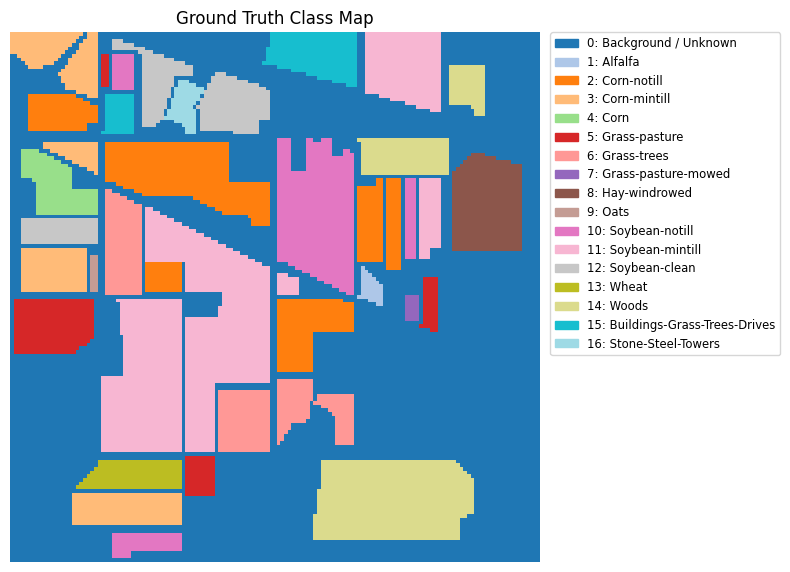

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

unique = np.unique(gt)
n_classes = len(unique)

# Choose a discrete colormap with enough distinct colors
cmap = plt.get_cmap('tab20', n_classes)  # discrete colormap

plt.figure(figsize=(8, 8))
im = plt.imshow(gt, cmap=cmap, vmin=unique.min(), vmax=unique.max(), interpolation='nearest')
plt.title('Ground Truth Class Map')
plt.axis('off')

# Build a legend (only include classes present in the GT)
patches = []
for c in unique:
    label = f"{int(c)}: {class_names.get(int(c), 'Unknown')}"
    color = cmap(np.where(unique == c)[0][0])  # color corresponding to this class in cmap
    patches.append(mpatches.Patch(color=color, label=label))

plt.legend(handles=patches, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0., fontsize='small')
plt.tight_layout()
plt.show()


**Visualize Spectral Signatures for Sample Classes**

We select one pixel from several different classes, extract their 200-dimensional spectral vectors, and plot them to compare how their spectral signatures differ. This demonstrates why hyperspectral data is powerful for classification.


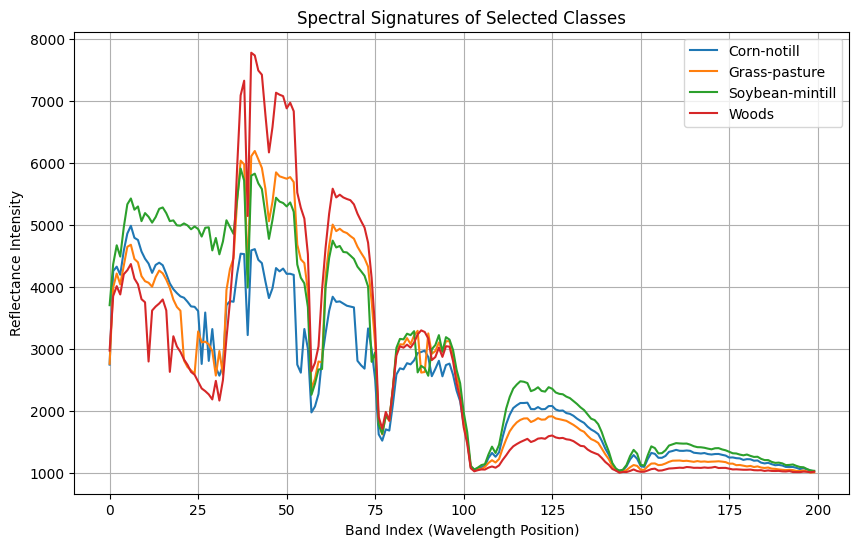

In [23]:
import random

# Pick a few class labels to visualize (avoid background 0)
classes_to_plot = [2, 5, 11, 14]   # Corn-notill, Grass-pasture, Soybean-mintill, Woods

spectral_signatures = {}

for cls in classes_to_plot:
    # Find all pixels belonging to this class
    coords = np.argwhere(gt == cls)

    # Pick one random pixel from that class
    y, x = coords[random.randint(0, len(coords)-1)]

    # Extract the spectral vector (200 values)
    spectrum = data[y, x, :]

    spectral_signatures[cls] = spectrum


# ---- Plot all chosen spectral signatures ----
plt.figure(figsize=(10,6))

for cls, spectrum in spectral_signatures.items():
    plt.plot(spectrum, label=class_names[cls])

plt.title("Spectral Signatures of Selected Classes")
plt.xlabel("Band Index (Wavelength Position)")
plt.ylabel("Reflectance Intensity")
plt.legend()
plt.grid(True)
plt.show()


 **Prepare Data for Classification (flatten cube → samples × features, remove background, stratified train/test split, scale features)**

This cell converts the 3D hyperspectral cube into a 2D sample-feature matrix, removes background pixels (label 0), builds `X` and `y`, performs a stratified train/test split, and scales features using `StandardScaler` (fit on train only).

In [24]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


H, W, B = data.shape
print("Height, Width, Bands:", H, W, B)

# 1) Flatten spatial dims -> list of pixels
# Reshape data: (H*W, B)
X_all = data.reshape(-1, B)   # each row is one pixel's spectral vector
y_all = gt.reshape(-1)        # corresponding labels

print("All samples shape:", X_all.shape, "All labels shape:", y_all.shape)

# 2) Remove background (label 0)
mask = (y_all != 0)
X = X_all[mask]
y = y_all[mask].astype(int)

print("After removing background -> X shape:", X.shape, "y shape:", y.shape)
print("Unique labels now:", np.unique(y))

# 3) Optional: show class distribution (quick check)
(unique, counts) = np.unique(y, return_counts=True)
print("Class distribution (label:count):")
for lab, cnt in zip(unique, counts):
    print(f"{lab:2d} : {cnt}")

# 4) Stratified train/test split so rare classes are represented
# If some classes are extremely tiny (like 20 samples), stratify will still keep representation,
# but be careful: very tiny classes may still be problematic for cross-validation.
test_size = 0.2
random_state = 42

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=random_state, stratify=y
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Train label counts:", np.unique(y_train, return_counts=True)[1])
print("Test label counts:", np.unique(y_test, return_counts=True)[1])

# 5) Scale features (fit on train only)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

print("Feature scaling done. Means (train) ~", np.round(X_train_scaled.mean(axis=0)[:5], 3), " (first 5 features shown)")


Height, Width, Bands: 145 145 200
All samples shape: (21025, 200) All labels shape: (21025,)
After removing background -> X shape: (10249, 200) y shape: (10249,)
Unique labels now: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
Class distribution (label:count):
 1 : 46
 2 : 1428
 3 : 830
 4 : 237
 5 : 483
 6 : 730
 7 : 28
 8 : 478
 9 : 20
10 : 972
11 : 2455
12 : 593
13 : 205
14 : 1265
15 : 386
16 : 93
Train shape: (8199, 200) Test shape: (2050, 200)
Train label counts: [  37 1142  664  190  386  584   23  382   16  778 1964  474  164 1012
  309   74]
Test label counts: [  9 286 166  47  97 146   5  96   4 194 491 119  41 253  77  19]
Feature scaling done. Means (train) ~ [ 0. -0. -0. -0. -0.]  (first 5 features shown)


**PCA + SVM Baseline (class_weight='balanced') and evaluation (classification report, confusion matrix, macro-F1, balanced accuracy)**

This pipeline reduces dimensionality with PCA then trains an SVM with a balanced class weight. It evaluates per-class precision/recall/F1 and confusion matrix.


PCA explained variance (first 5): [0.687 0.189 0.03  0.017 0.012]
Total explained variance (30 comps): 0.986
Balanced accuracy: 0.8421920354647388
Macro F1 score: 0.7767224887275408

Classification Report:

              precision    recall  f1-score   support

           1      0.529     1.000     0.692         9
           2      0.776     0.594     0.673       286
           3      0.709     0.572     0.633       166
           4      0.382     0.894     0.535        47
           5      0.885     0.876     0.881        97
           6      0.883     0.932     0.907       146
           7      0.833     1.000     0.909         5
           8      1.000     0.927     0.962        96
           9      0.571     1.000     0.727         4
          10      0.625     0.814     0.707       194
          11      0.797     0.688     0.739       491
          12      0.540     0.731     0.621       119
          13      0.909     0.976     0.941        41
          14      0.925     0.925   

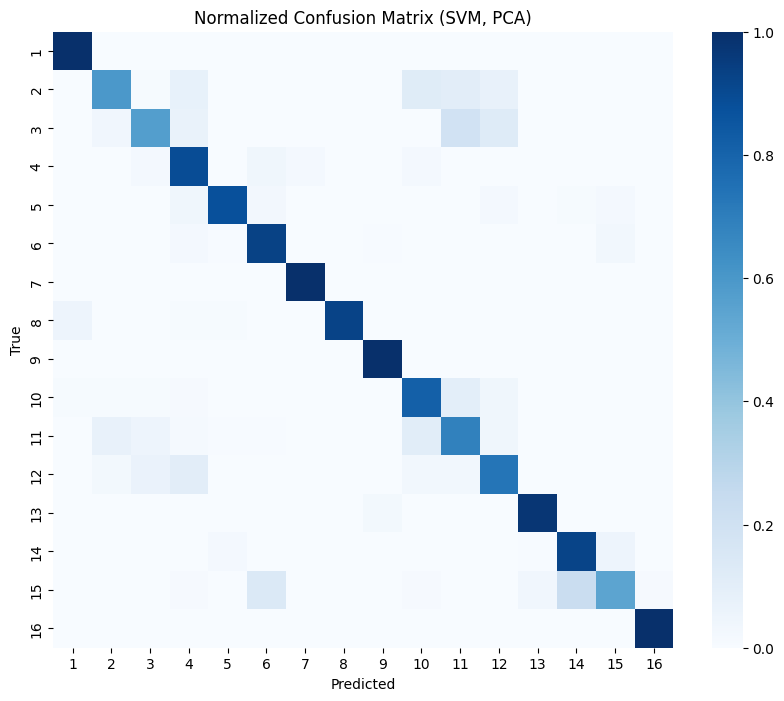

In [25]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# X_train_scaled, X_test_scaled, y_train, y_test already available from Step 7

# 1) PCA to reduce dimensionality (keep 30 components as starting point)
n_components = 30
pca = PCA(n_components=n_components, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca  = pca.transform(X_test_scaled)

print("PCA explained variance (first 5):", np.round(pca.explained_variance_ratio_[:5], 3))
print("Total explained variance (30 comps):", np.round(pca.explained_variance_ratio_.sum(), 3))

# 2) Train SVM with class_weight='balanced'
svm = SVC(kernel='rbf', class_weight='balanced', C=1.0, gamma='scale', random_state=42)
svm.fit(X_train_pca, y_train)

# 3) Predict & evaluate
y_pred = svm.predict(X_test_pca)

print("Balanced accuracy:", balanced_accuracy_score(y_test, y_pred))
print("Macro F1 score:", f1_score(y_test, y_pred, average='macro'))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, digits=3))

# 4) Confusion matrix visualization (normalized)
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10,8))
sns.heatmap(cm_norm, annot=False, cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix (SVM, PCA)')
plt.show()


**K-Nearest Neighbors Baseline and evaluation**
A simple KNN baseline (k=5 by default). Useful for a quick, interpretable benchmark.


In [26]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, balanced_accuracy_score, f1_score

# Option: apply PCA used above for speed (recommended)
X_train_knn = X_train_pca  # use PCA outputs from Step 8A to speed up
X_test_knn  = X_test_pca

knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
knn.fit(X_train_knn, y_train)
y_knn = knn.predict(X_test_knn)

print("Balanced accuracy (KNN):", balanced_accuracy_score(y_test, y_knn))
print("Macro F1 (KNN):", f1_score(y_test, y_knn, average='macro'))
print("\nClassification Report (KNN):\n")
print(classification_report(y_test, y_knn, digits=3))


Balanced accuracy (KNN): 0.6857190835518627
Macro F1 (KNN): 0.714077250179027

Classification Report (KNN):

              precision    recall  f1-score   support

           1      0.600     0.333     0.429         9
           2      0.588     0.664     0.624       286
           3      0.704     0.572     0.631       166
           4      0.594     0.404     0.481        47
           5      0.896     0.887     0.891        97
           6      0.792     0.966     0.870       146
           7      1.000     0.800     0.889         5
           8      0.893     0.958     0.925        96
           9      1.000     0.250     0.400         4
          10      0.726     0.778     0.751       194
          11      0.743     0.813     0.776       491
          12      0.632     0.361     0.460       119
          13      0.854     1.000     0.921        41
          14      0.938     0.953     0.945       253
          15      0.769     0.390     0.517        77
          16      1.000   

 **Step 9 Code: Compute 3x3 neighborhood mean spectrum, build spectral-spatial features, PCA, train SVM, evaluate**


Data shape: (145, 145, 200)
Computed neighborhood mean shape: (145, 145, 200)
Fused feature shape (all pixels): (21025, 400)
After removing background -> X_fused shape: (10249, 400) y_fused shape: (10249,)
Class counts (fused):
 1 : 46
 2 : 1428
 3 : 830
 4 : 237
 5 : 483
 6 : 730
 7 : 28
 8 : 478
 9 : 20
10 : 972
11 : 2455
12 : 593
13 : 205
14 : 1265
15 : 386
16 : 93
Train shape (fused): (8199, 400) Test shape (fused): (2050, 400)
Fused PCA explained variance (sum): 0.985
First 5 explained: [0.7   0.183 0.03  0.017 0.011]
Balanced accuracy (fused): 0.8935164642043025
Macro F1 (fused): 0.8316264095706909

Classification Report (fused SVM):

              precision    recall  f1-score   support

           1      0.643     1.000     0.783         9
           2      0.845     0.706     0.770       286
           3      0.741     0.723     0.732       166
           4      0.455     0.979     0.622        47
           5      0.908     0.918     0.913        97
           6      0.966   

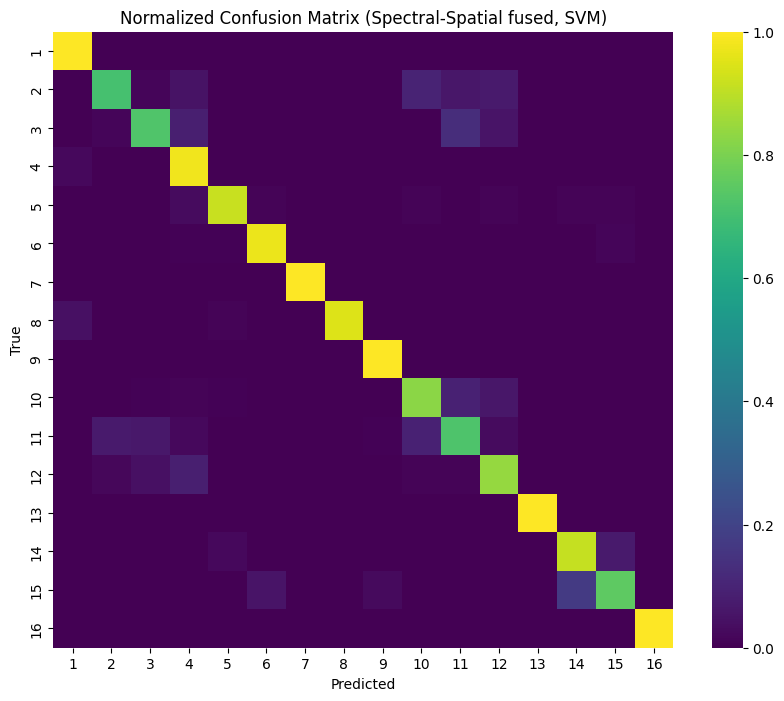

In [27]:
# --- Step 9 code ---
import numpy as np
from scipy.ndimage import uniform_filter
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report, balanced_accuracy_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure data and gt exist
# data.shape -> (H, W, B)
H, W, B = data.shape
print("Data shape:", data.shape)

# 1) Compute neighborhood mean spectrum (3x3) for each band using uniform_filter (fast)
# uniform_filter computes local mean; we apply per-band
# result: neigh_mean shape (H, W, B)
neigh_mean = np.empty_like(data)
for b in range(B):
    # uniform_filter with size=3 computes mean over 3x3 window
    neigh_mean[:, :, b] = uniform_filter(data[:, :, b], size=3, mode='reflect')

print("Computed neighborhood mean shape:", neigh_mean.shape)

# 2) Build fused features: concatenate original spectrum + neighborhood mean (per pixel)
# Flatten spatial dims: (H*W, B)
X_orig = data.reshape(-1, B)
X_neigh = neigh_mean.reshape(-1, B)

# Concatenate: (H*W, 2*B)
X_fused_all = np.concatenate([X_orig, X_neigh], axis=1)
print("Fused feature shape (all pixels):", X_fused_all.shape)

# Labels (flattened)
y_all = gt.reshape(-1)

# Remove background
mask = (y_all != 0)
X_fused = X_fused_all[mask]
y_fused = y_all[mask].astype(int)

print("After removing background -> X_fused shape:", X_fused.shape, "y_fused shape:", y_fused.shape)

# Quick distribution check
unique, counts = np.unique(y_fused, return_counts=True)
print("Class counts (fused):")
for lab, cnt in zip(unique, counts):
    print(f"{lab:2d} : {cnt}")

# 3) Use the same train/test split approach as before (stratified)
from sklearn.model_selection import train_test_split
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(
    X_fused, y_fused, test_size=0.2, random_state=42, stratify=y_fused
)

print("Train shape (fused):", X_train_f.shape, "Test shape (fused):", X_test_f.shape)

# 4) Scale features (fit on train only)
scaler_f = StandardScaler()
X_train_f_scaled = scaler_f.fit_transform(X_train_f)
X_test_f_scaled  = scaler_f.transform(X_test_f)

# 5) PCA to reduce dimensionality (we'll try 30 comps as before)
n_components = 30
pca_f = PCA(n_components=n_components, random_state=42)
X_train_f_pca = pca_f.fit_transform(X_train_f_scaled)
X_test_f_pca  = pca_f.transform(X_test_f_scaled)

print("Fused PCA explained variance (sum):", np.round(pca_f.explained_variance_ratio_.sum(), 3))
print("First 5 explained:", np.round(pca_f.explained_variance_ratio_[:5], 3))

# 6) Train SVM with class_weight balanced
svm_f = SVC(kernel='rbf', class_weight='balanced', C=1.0, gamma='scale', random_state=42)
svm_f.fit(X_train_f_pca, y_train_f)

# 7) Predict & evaluate
y_pred_f = svm_f.predict(X_test_f_pca)

bal_acc_f = balanced_accuracy_score(y_test_f, y_pred_f)
macro_f1_f = f1_score(y_test_f, y_pred_f, average='macro')
print("Balanced accuracy (fused):", bal_acc_f)
print("Macro F1 (fused):", macro_f1_f)
print("\nClassification Report (fused SVM):\n")
print(classification_report(y_test_f, y_pred_f, digits=3))

# 8) Confusion matrix (normalized by true count)
cm_f = confusion_matrix(y_test_f, y_pred_f, labels=np.unique(y_test_f))
cm_f_norm = cm_f.astype('float') / cm_f.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10,8))
sns.heatmap(cm_f_norm, annot=False, cmap='viridis', xticklabels=np.unique(y_test_f), yticklabels=np.unique(y_test_f))
plt.title('Normalized Confusion Matrix (Spectral-Spatial fused, SVM)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


 **Generate and Visualize the Full Classification Map Using the Spectral–Spatial SVM Model**


Fused features for full image: (21025, 400)
After PCA: (21025, 30)
Predictions: (21025,)
Pred map shape: (145, 145)


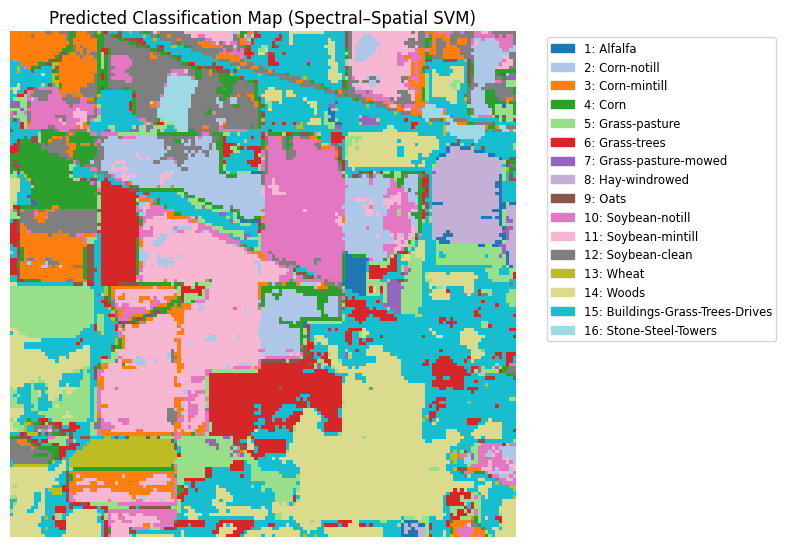

In [28]:
# Flatten original + neighborhood means
X_orig_all = data.reshape(-1, B)
X_neigh_all = neigh_mean.reshape(-1, B)

X_fused_all_pixels = np.concatenate([X_orig_all, X_neigh_all], axis=1)

print("Fused features for full image:", X_fused_all_pixels.shape)


# ----- 2. Scale & PCA transform using TRAINED scaler_f and PCA_f -----
X_fused_all_scaled = scaler_f.transform(X_fused_all_pixels)
X_fused_all_pca = pca_f.transform(X_fused_all_scaled)

print("After PCA:", X_fused_all_pca.shape)


# ----- 3. Predict using trained fused SVM -----
y_pred_full = svm_f.predict(X_fused_all_pca)
print("Predictions:", y_pred_full.shape)


# ----- 4. Reshape to 2D map -----
pred_map = y_pred_full.reshape(H, W)
print("Pred map shape:", pred_map.shape)


# ----- 5. Visualize predicted map with legend -----
plt.figure(figsize=(8, 8))

# use same colormap as earlier
unique_pred = np.unique(pred_map)
cmap = plt.get_cmap('tab20', len(unique_pred))

plt.imshow(pred_map, cmap=cmap, vmin=unique_pred.min(), vmax=unique_pred.max())
plt.title("Predicted Classification Map (Spectral–Spatial SVM)")
plt.axis("off")

# Legend patches
import matplotlib.patches as mpatches

patches = []
for c in unique_pred:
    label = f"{c}: {class_names.get(int(c), 'Unknown')}"
    idx = np.where(unique_pred == c)[0][0]
    color = cmap(idx)
    patches.append(mpatches.Patch(color=color, label=label))

plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc="upper left", fontsize="small")
plt.tight_layout()
plt.show()


 **Visual Comparison — Ground Truth vs Predicted Classification Map**
This cell displays the ground-truth class map and the predicted class map next to each other with a shared legend. Run this after you have `gt`, `pred_map`, and `class_names` loaded in Colab.


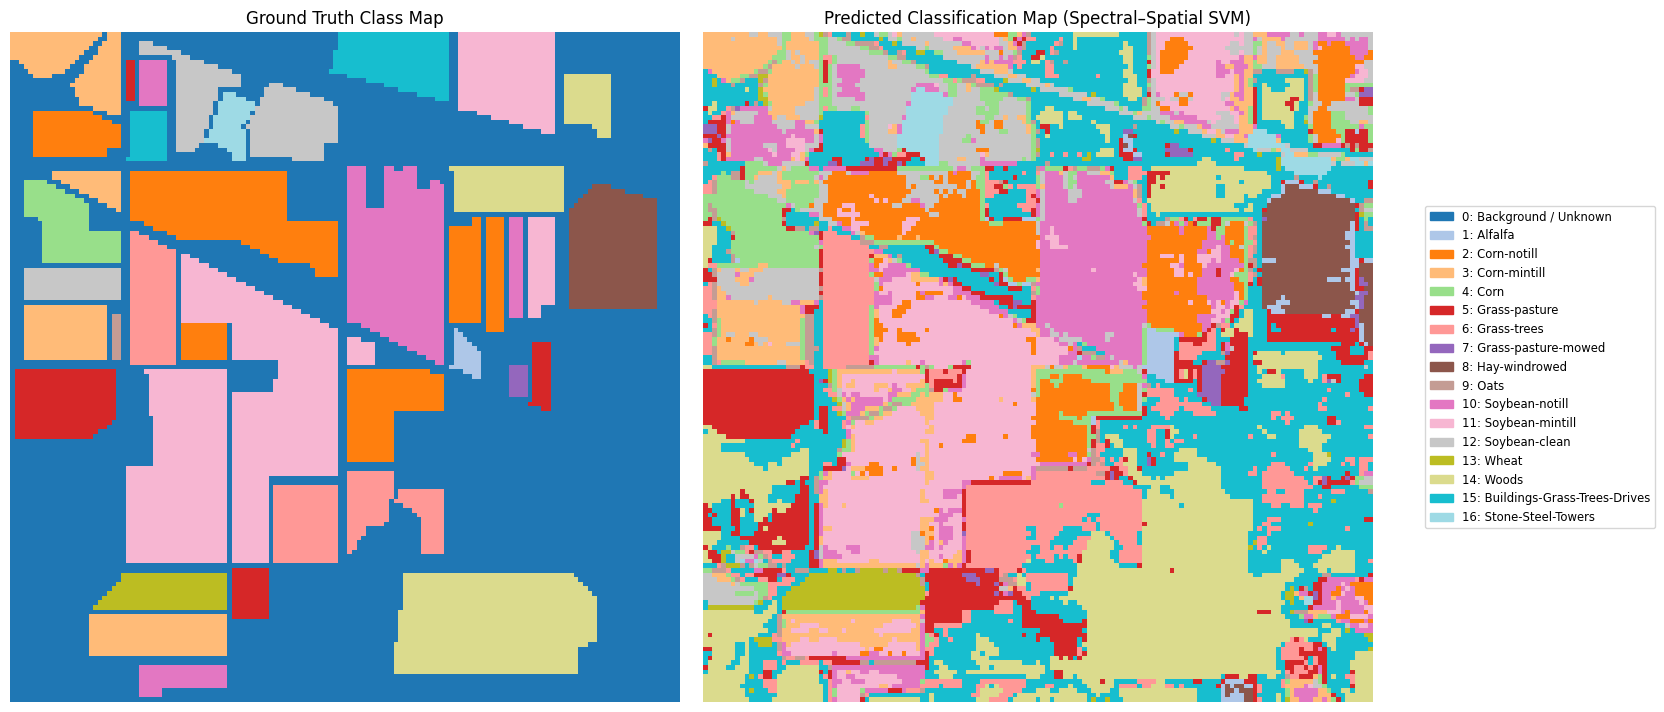

In [29]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap

# gt: ground truth 2D array (H, W)
# pred_map: predicted 2D array (H, W)

unique_all = np.unique(np.concatenate([gt.flatten(), pred_map.flatten()]))
n_unique = len(unique_all)

# Use a discrete colormap large enough
cmap = plt.get_cmap('tab20', n_unique)

fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Left: Ground Truth (display 0 too so you can visually compare background)
im0 = axes[0].imshow(gt, cmap=cmap, vmin=unique_all.min(), vmax=unique_all.max(), interpolation='nearest')
axes[0].set_title("Ground Truth Class Map")
axes[0].axis('off')

# Right: Prediction
im1 = axes[1].imshow(pred_map, cmap=cmap, vmin=unique_all.min(), vmax=unique_all.max(), interpolation='nearest')
axes[1].set_title("Predicted Classification Map (Spectral–Spatial SVM)")
axes[1].axis('off')

# Build a legend using the union of labels present
patches = []
for c in unique_all:
    label = f"{int(c)}: {class_names.get(int(c), 'Unknown')}"
    idx = np.where(unique_all == c)[0][0]
    color = cmap(idx)
    patches.append(mpatches.Patch(color=color, label=label))

# Place the legend to the right
fig.legend(handles=patches, bbox_to_anchor=(1.02, 0.5), loc='center left', fontsize='small')
plt.tight_layout()
plt.show()
